# import module

In [1]:
import os
import sys
import random
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

# %matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add, SeparableConv2D,Concatenate,SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
import time
t_start = time.time()

Using TensorFlow backend.


# prepare data

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
SAVE MODEL:Unet_resnet_v50.0.model
SUBMISSION FILE:Unet_resnet_v50.0.csv
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
4000


/home/kylin/anaconda3/envs/py3.6/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5,0,'Coverage class')

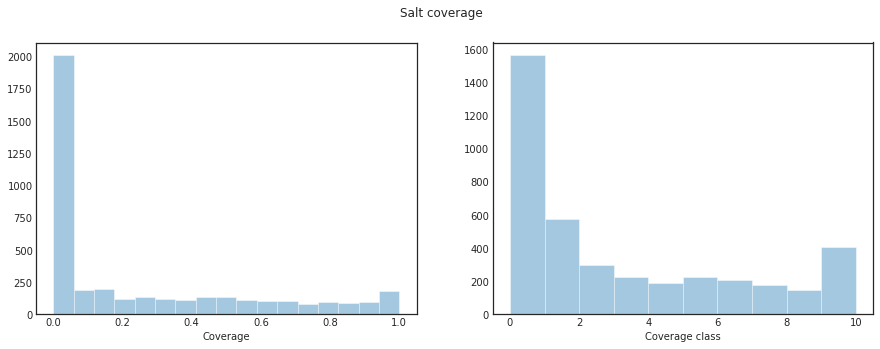

In [2]:
version = 50
tmp = 0

save_basic_name = f'Unet_resnet_v{version}.{tmp}'
save_model_name = save_basic_name + '.model'
submission_file = save_basic_name + '.csv'

print('-*-'*30)
print('SAVE MODEL:'+save_model_name)
print('SUBMISSION FILE:'+submission_file)
print('-*-'*30)


img_size_ori = 101
img_size_target = 128


def upsample(img):  # not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)


def downsample(img):  # not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths
train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print(len(train_df))

train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)


def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i:
            return i

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
# plt.show()
#Plotting the depth distributions¶

Text(0.5,1,'Depth distribution')

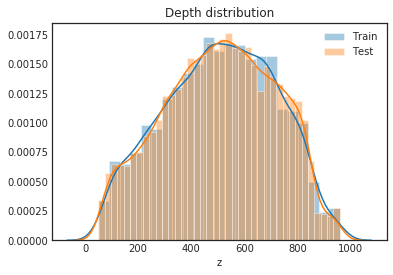

In [3]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# split train/valid

In [4]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, 101, 101, 1),
    np.array(train_df.masks.tolist()).reshape(-1, 101, 101, 1),
    # np.array(train_df.images.map(transfer).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    # np.array(train_df.masks.map(transfer).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

# transform augmentation 

In [5]:
################### transform augmentation  ###########################
import cv2
import numpy as np
import math
import os
import random

#################################################################

def do_resize2(image, mask, H, W):
    image = cv2.resize(image,dsize=(W,H))
    mask = cv2.resize(mask,dsize=(W,H))
#     image = cv2.copyMakeboarder(image,11,11,11,11,BORDER_REFLECT_101)
#     mask = cv2.copyMakeboarder(mask,11,11,11,11,BORDER_REFLECT_101)
    mask  = (mask>0.5).astype(np.float32)

    return image,mask

#################################################################

def compute_center_pad(H,W, factor=32):

    if H%factor==0:
        dy0,dy1=0,0
    else:
        dy  = factor - H%factor
        dy0 = dy//2
        dy1 = dy - dy0

    if W%factor==0:
        dx0,dx1=0,0
    else:
        dx  = factor - W%factor
        dx0 = dx//2
        dx1 = dx - dx0

    return dy0, dy1, dx0, dx1


def do_center_pad_to_factor(image, factor=32):
    H,W = image.shape[:2]
    dy0, dy1, dx0, dx1 = compute_center_pad(H,W, factor)

    image = cv2.copyMakeBorder(image, dy0, dy1, dx0, dx1, cv2.BORDER_REFLECT_101)
                               #cv2.BORDER_CONSTANT, 0)
    return image


def do_center_pad_to_factor2(image, mask, factor=32):
    image = do_center_pad_to_factor(image, factor)
    mask  = do_center_pad_to_factor(mask, factor)
    return image, mask

################################################

def do_horizontal_flip(image):
    #flip left-right
    image = cv2.flip(image,1)
    return image

def do_horizontal_flip2(image,mask):
    image = do_horizontal_flip(image)
    mask  = do_horizontal_flip(mask )
    return image, mask

##################################################

def compute_random_pad(H,W, limit=(-4,4), factor=32):


    if H%factor==0:
        dy0,dy1=0,0
    else:
        dy  = factor - H%factor
        dy0 = dy//2 + np.random.randint(limit[0],limit[1]) # np.random.choice(dy)
        dy1 = dy - dy0

    if W%factor==0:
        dx0,dx1=0,0
    else:
        dx  = factor - W%factor
        dx0 = dx//2 + np.random.randint(limit[0],limit[1]) # np.random.choice(dx)
        dx1 = dx - dx0

    return dy0, dy1, dx0, dx1


def do_random_pad_to_factor2(image, mask, limit=(-4,4), factor=32):
    H,W = image.shape[:2]
    dy0, dy1, dx0, dx1 = compute_random_pad(H,W, limit, factor)

    image = cv2.copyMakeBorder(image, dy0, dy1, dx0, dx1, cv2.BORDER_REFLECT_101)
    mask  = cv2.copyMakeBorder(mask,  dy0, dy1, dx0, dx1, cv2.BORDER_REFLECT_101)

    return image, mask

#####################################################

def do_invert_intensity(image):
    #flip left-right
    image = np.clip(1-image,0,1)
    return image


def do_brightness_shift(image, alpha=0.125):
    image = image + alpha
    image = np.clip(image, 0, 1)
    return image


def do_brightness_multiply(image, alpha=1):
    image = alpha*image
    image = np.clip(image, 0, 1)
    return image


#https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def do_gamma(image, gamma=1.0):

    image = image ** (1.0 / gamma)
    image = np.clip(image, 0, 1)
    return image

#################################################

def do_flip_transpose2(image, mask, type=0):
    #choose one of the 8 cases

    if type==0: #rotate90
        image = image.transpose(1,0)
        image = cv2.flip(image,1)

        mask = mask.transpose(1,0)
        mask = cv2.flip(mask,1)


    if type==1: #rotate180
        image = cv2.flip(image,-1)
        mask  = cv2.flip(mask,-1)


    if type==2: #rotate270
        image = image.transpose(1,0)
        image = cv2.flip(image,0)

        mask = mask.transpose(1,0)
        mask = cv2.flip(mask,0)


    if type==3: #flip left-right
        image = cv2.flip(image,1)
        mask  = cv2.flip(mask,1)


    if type==4: #flip up-down
        image = cv2.flip(image,0)
        mask  = cv2.flip(mask,0)

    if type==5:
        image = cv2.flip(image,1)
        image = image.transpose(1,0)
        image = cv2.flip(image,1)

        mask = cv2.flip(mask,1)
        mask = mask.transpose(1,0)
        mask = cv2.flip(mask,1)

    if type==6:
        image = cv2.flip(image,0)
        image = image.transpose(1,0)
        image = cv2.flip(image,1)

        mask = cv2.flip(mask,0)
        mask = mask.transpose(1,0)
        mask = cv2.flip(mask,1)


    return image, mask

###############################################################

def do_shift_scale_crop( image, mask, x0=0, y0=0, x1=1, y1=1 ):
    #cv2.BORDER_REFLECT_101
    #cv2.BORDER_CONSTANT

    height, width = image.shape[:2]
    image = image[y0:y1,x0:x1]
    mask  = mask [y0:y1,x0:x1]

    image = cv2.resize(image,dsize=(width,height))
    mask  = cv2.resize(mask,dsize=(width,height))
    mask  = (mask>0.5).astype(np.float32)
    return image, mask


def do_random_shift_scale_crop_pad2(image, mask, limit=0.10):

    H, W = image.shape[:2]

    dy = int(H*limit)
    y0 =   np.random.randint(0,dy)
    y1 = H-np.random.randint(0,dy)

    dx = int(W*limit)
    x0 =   np.random.randint(0,dx)
    x1 = W-np.random.randint(0,dx)

    #y0, y1, x0, x1
    image, mask = do_shift_scale_crop( image, mask, x0, y0, x1, y1 )
    return image, mask

#===========================================================================

def do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=0 ):
    borderMode=cv2.BORDER_REFLECT_101
    #cv2.BORDER_REFLECT_101  cv2.BORDER_CONSTANT

    height, width = image.shape[:2]
    sx = scale
    sy = scale
    cc = math.cos(angle/180*math.pi)*(sx)
    ss = math.sin(angle/180*math.pi)*(sy)
    rotate_matrix = np.array([ [cc,-ss], [ss,cc] ])

    box0 = np.array([ [0,0], [width,0],  [width,height], [0,height], ],np.float32)
    box1 = box0 - np.array([width/2,height/2])
    box1 = np.dot(box1,rotate_matrix.T) + np.array([width/2+dx,height/2+dy])

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat  = cv2.getPerspectiveTransform(box0,box1)

    image = cv2.warpPerspective(image, mat, (width,height),flags=cv2.INTER_LINEAR,
                                borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask = cv2.warpPerspective(mask, mat, (width,height),flags=cv2.INTER_NEAREST,#cv2.INTER_LINEAR
                                borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask  = (mask>0.5).astype(np.float32)
    return image, mask

#https://www.kaggle.com/ori226/data-augmentation-with-elastic-deformations
#https://github.com/letmaik/lensfunpy/blob/master/lensfunpy/util.py
def do_elastic_transform2(image, mask, grid=32, distort=0.2):
    borderMode=cv2.BORDER_REFLECT_101
    height, width = image.shape[:2]

    x_step = int(grid)
    xx = np.zeros(width,np.float32)
    prev = 0
    for x in range(0, width, x_step):
        start = x
        end   = x + x_step
        if end > width:
            end = width
            cur = width
        else:
            cur = prev + x_step*(1+random.uniform(-distort,distort))

        xx[start:end] = np.linspace(prev,cur,end-start)
        prev=cur


    y_step = int(grid)
    yy = np.zeros(height,np.float32)
    prev = 0
    for y in range(0, height, y_step):
        start = y
        end   = y + y_step
        if end > height:
            end = height
            cur = height
        else:
            cur = prev + y_step*(1+random.uniform(-distort,distort))

        yy[start:end] = np.linspace(prev,cur,end-start)
        prev=cur

    #grid
    map_x,map_y =  np.meshgrid(xx, yy)
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)

    #image = map_coordinates(image, coords, order=1, mode='reflect').reshape(shape)
    image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=borderMode,borderValue=(0,0,0,))


    mask = cv2.remap(mask, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=borderMode,borderValue=(0,0,0,))
    mask  = (mask>0.5).astype(np.float32)
    return image, mask




def do_horizontal_shear2( image, mask, dx=0 ):
    borderMode=cv2.BORDER_REFLECT_101
    #cv2.BORDER_REFLECT_101  cv2.BORDER_CONSTANT

    height, width = image.shape[:2]
    dx = int(dx*width)

    box0 = np.array([ [0,0], [width,0],  [width,height], [0,height], ],np.float32)
    box1 = np.array([ [+dx,0], [width+dx,0],  [width-dx,height], [-dx,height], ],np.float32)

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat = cv2.getPerspectiveTransform(box0,box1)

    image = cv2.warpPerspective(image, mat, (width,height),flags=cv2.INTER_LINEAR,
                                borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask  = cv2.warpPerspective(mask, mat, (width,height),flags=cv2.INTER_NEAREST,#cv2.INTER_LINEAR
                                borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask  = (mask>0.5).astype(np.float32)
    return image, mask
def transform(imgs, masks, config):
    transform_imgs = []
    transform_masks = []
    for id in range(len(imgs)):
        img, mask = np.squeeze(imgs[id], axis=2), np.squeeze(masks[id],axis=2)
        if config['do_center_pad_to_factor']:
            img, mask = do_center_pad_to_factor2(img, mask)
        if config['do_random_shift_scale_crop_pad']:
            img, mask = do_random_shift_scale_crop_pad2(img, mask)
        if config['do_random_pad_to_factor']:
            img, mask = do_random_pad_to_factor2(img, mask)
        if config['do_shift_scale_rotate']:
            img, mask = do_shift_scale_rotate2(img, mask)
        if config['do_horizontal_flip'] and np.random.randint(2):
            img, mask = do_horizontal_flip2(img, mask)
        if config['do_horizontal_shear'] and np.random.randint(2):
            img, mask = do_horizontal_shear2(img, mask)
        if config['do_elastic_transform'] and np.random.randint(2):
            img, mask = do_elastic_transform2(img, mask)
        if config['do_flip_transpose'] and np.random.randint(2):
            img, mask = do_flip_transpose2(img, mask, type=np.random.choice(5))
        if config['do_brightness_shift'] and np.random.randint(2):
            img = do_brightness_shift(img)
        if config['do_brightness_multiply'] and np.random.randint(2):
            img = do_brightness_multiply(img, np.random.uniform(0.92, 1.08))
        if config['do_gamma'] and np.random.randint(2):
            img = do_gamma(img)
        if config['do_invert_intensity'] and np.random.randint(2):
            img = do_invert_intensity(img)
        if not img_size_ori == img_size_target and config['doresize']:
            img, mask = do_resize2(img, mask, img_size_target, img_size_target)

        transform_imgs.append(img)
        transform_masks.append(mask)
    return np.array(transform_imgs).reshape(-1, img_size_target, img_size_target, 1), \
           np.array(transform_masks).reshape(-1, img_size_target, img_size_target, 1)

def valid_transform(imgs, masks, config):
    valid_transform_imgs = []
    valid_trasnform_masks = []
    for id in range(len(imgs)):
        img, mask = np.squeeze(imgs[id], axis=2), np.squeeze(masks[id],axis=2)

        if not img_size_ori == img_size_target and config['doresize']:
            img, mask = do_resize2(img, mask, img_size_target, img_size_target)
        valid_transform_imgs.append(img)
        valid_trasnform_masks.append(mask)
    return np.array(valid_transform_imgs).reshape(-1, img_size_target, img_size_target, 1), \
           np.array(valid_trasnform_masks).reshape(-1, img_size_target, img_size_target, 1)


CONFIG = {'doresize': True, 'do_flip_transpose': False,
                   'do_center_pad_to_factor': False,
                   'do_random_shift_scale_crop_pad': True,
                   'do_random_pad_to_factor': False,
                   'do_horizontal_flip': False,
                   'do_horizontal_shear': False,
                   'do_elastic_transform': False,
                   'do_brightness_multiply': False,
                   'do_brightness_shift': False, 'do_gamma': False,
                   'do_shift_scale_rotate': False,
                   'do_invert_intensity': False
                   }
###################  end  transform  define  #############################

# Build U-Net Model

In [6]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv
K.clear_session()
def get_unet_resnet(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False)

    for l in resnet_base.layers:
        l.trainable = True
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    conv6 = conv_block_simple(up6, 256, "conv6_1")
    conv6 = conv_block_simple(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    conv7 = conv_block_simple(up7, 192, "conv7_1")
    conv7 = conv_block_simple(conv7, 192, "conv7_2")

    up8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")
    conv8 = conv_block_simple(conv8, 128, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(up10, 32, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)
    output_layer_noActi = Conv2D(1, (1, 1), activation=None, name="prediction")(conv10)
    x = Activation('sigmoid')(output_layer_noActi)

    model = Model(resnet_base.input, x)
    return model
import warnings

# from keras.applications.imagenet_utils import _obtain_input_shape
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 50

In [7]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1_0')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     if include_top:
#         x = Flatten()(x)
#         x = Dense(classes, activation='softmax', name='fc1000')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,by_name=True)
    return model
def relu6(x):
    return K.relu(x, max_value=6)

# Define Loss Function

In [8]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [9]:
###################  Data augmentation  ############################
x1_train = x_train
y1_train = y_train

x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# x_train = np.append(x_train, [np.flipud(x) for x in x_train], axis=0)
# y_train = np.append(y_train, [np.flipud(x) for x in y_train], axis=0)
x1_train, y1_train = transform(x1_train,y1_train, CONFIG)
x_valid, y_valid = valid_transform(x_valid, y_valid, CONFIG)
x_train, y_train = valid_transform(x_train, y_train, CONFIG)
x_train = np.concatenate((x_train, x1_train), axis=0)
y_train = np.concatenate((y_train, y1_train), axis=0)

print('x_train:{}'.format(x_train.shape))
print('y_train:{}'.format(y_train.shape))
print('x_valid:{}'.format(x_valid.shape))
print('y_valid:{}'.format(y_valid.shape))
print('-*-'*30)

x_train:(9600, 128, 128, 1)
y_train:(9600, 128, 128, 1)
x_valid:(800, 128, 128, 1)
y_valid:(800, 128, 128, 1)
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

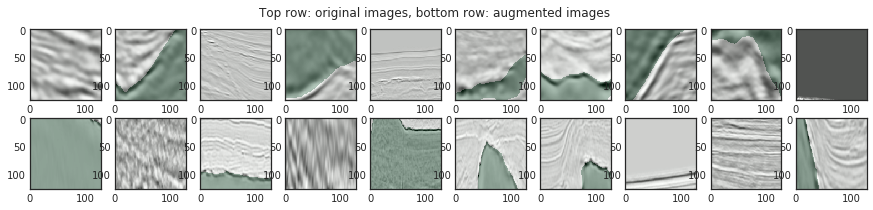

In [10]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [11]:
model = get_unet_resnet(input_shape=(img_size_target,img_size_target,1))
model.compile(loss=bce_dice_loss, optimizer="adam", metrics=[my_iou_metric])
early_stopping = EarlyStopping(monitor='val_my_iou_metric',patience=25,mode='max', verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric',mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1,monitor='val_my_iou_metric',mode='max', patience=10, verbose=1)

epochs = 60
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping,reduce_lr, model_checkpoint],shuffle=True,verbose=1)

Train on 9600 samples, validate on 800 samples
Epoch 1/60
9600/9600 [==============================] - 79s 8ms/step - loss: 0.6412 - my_iou_metric: 0.5191 - val_loss: 1.1442 - val_my_iou_metric: 0.2726

Epoch 00001: val_my_iou_metric improved from -inf to 0.27263, saving model to Unet_resnet_v50.0.model
Epoch 2/60
9600/9600 [==============================] - 62s 6ms/step - loss: 0.4720 - my_iou_metric: 0.6112 - val_loss: 1.1997 - val_my_iou_metric: 0.2401

Epoch 00002: val_my_iou_metric did not improve from 0.27263
Epoch 3/60
9600/9600 [==============================] - 62s 6ms/step - loss: 0.4316 - my_iou_metric: 0.6492 - val_loss: 1.5015 - val_my_iou_metric: 0.3349

Epoch 00003: val_my_iou_metric improved from 0.27263 to 0.33488, saving model to Unet_resnet_v50.0.model
Epoch 4/60
9600/9600 [==============================] - 62s 7ms/step - loss: 0.3833 - my_iou_metric: 0.6771 - val_loss: 0.3950 - val_my_iou_metric: 0.6564

Epoch 00004: val_my_iou_metric improved from 0.33488 to 0.6563

9600/9600 [==============================] - 63s 7ms/step - loss: 0.0515 - my_iou_metric: 0.8840 - val_loss: 0.3888 - val_my_iou_metric: 0.7331

Epoch 00037: val_my_iou_metric did not improve from 0.75575
Epoch 38/60
9600/9600 [==============================] - 62s 6ms/step - loss: 0.0509 - my_iou_metric: 0.8851 - val_loss: 0.3949 - val_my_iou_metric: 0.7380

Epoch 00038: val_my_iou_metric did not improve from 0.75575
Epoch 39/60
9600/9600 [==============================] - 62s 7ms/step - loss: 0.0508 - my_iou_metric: 0.8838 - val_loss: 0.3940 - val_my_iou_metric: 0.7368

Epoch 00039: val_my_iou_metric did not improve from 0.75575
Epoch 40/60
9600/9600 [==============================] - 62s 7ms/step - loss: 0.0502 - my_iou_metric: 0.8854 - val_loss: 0.3955 - val_my_iou_metric: 0.7373

Epoch 00040: val_my_iou_metric did not improve from 0.75575
Epoch 41/60
9600/9600 [==============================] - 62s 6ms/step - loss: 0.0498 - my_iou_metric: 0.8846 - val_loss: 0.3965 - val_my_iou_met

In [12]:

##################################################################
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
##################################################################
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
LOAD MODEL:Unet_resnet_v50.0.model
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv1_0 (Conv2D)                (None, 64, 64, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1_0[0][0]                    
__________________________________________________________________________________________

Train on 9600 samples, validate on 800 samples
Epoch 1/150
 - 189s - loss: 0.8793 - my_iou_metric_2: 0.5431 - val_loss: 1.6085 - val_my_iou_metric_2: 0.3688

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.36875, saving model to Unet_resnet_v50.0.model
Epoch 2/150
 - 177s - loss: 0.8586 - my_iou_metric_2: 0.5494 - val_loss: 1.3623 - val_my_iou_metric_2: 0.3679

Epoch 00002: val_my_iou_metric_2 did not improve from 0.36875
Epoch 3/150
 - 177s - loss: 0.9148 - my_iou_metric_2: 0.4984 - val_loss: 2.8887 - val_my_iou_metric_2: 0.1487

Epoch 00003: val_my_iou_metric_2 did not improve from 0.36875
Epoch 4/150
 - 176s - loss: 0.9793 - my_iou_metric_2: 0.4387 - val_loss: 1.0227 - val_my_iou_metric_2: 0.3900

Epoch 00004: val_my_iou_metric_2 improved from 0.36875 to 0.39000, saving model to Unet_resnet_v50.0.model
Epoch 5/150
 - 176s - loss: 1.0018 - my_iou_metric_2: 0.3254 - val_loss: 1.0008 - val_my_iou_metric_2: 0.3781

Epoch 00005: val_my_iou_metric_2 did not improve from 0.39000
E


Epoch 00043: val_my_iou_metric_2 did not improve from 0.72988
Epoch 44/150
 - 177s - loss: 0.4522 - my_iou_metric_2: 0.7520 - val_loss: 0.4600 - val_my_iou_metric_2: 0.7421

Epoch 00044: val_my_iou_metric_2 improved from 0.72988 to 0.74212, saving model to Unet_resnet_v50.0.model
Epoch 45/150
 - 177s - loss: 0.4683 - my_iou_metric_2: 0.7433 - val_loss: 0.4744 - val_my_iou_metric_2: 0.7419

Epoch 00045: val_my_iou_metric_2 did not improve from 0.74212
Epoch 46/150
 - 177s - loss: 0.4383 - my_iou_metric_2: 0.7572 - val_loss: 0.5562 - val_my_iou_metric_2: 0.7006

Epoch 00046: val_my_iou_metric_2 did not improve from 0.74212
Epoch 47/150
 - 177s - loss: 0.4261 - my_iou_metric_2: 0.7633 - val_loss: 0.5002 - val_my_iou_metric_2: 0.7269

Epoch 00047: val_my_iou_metric_2 did not improve from 0.74212
Epoch 48/150
 - 177s - loss: 0.4175 - my_iou_metric_2: 0.7687 - val_loss: 0.4580 - val_my_iou_metric_2: 0.7490

Epoch 00048: val_my_iou_metric_2 improved from 0.74212 to 0.74900, saving model to U

 - 176s - loss: 0.2578 - my_iou_metric_2: 0.8494 - val_loss: 0.3975 - val_my_iou_metric_2: 0.7834

Epoch 00087: val_my_iou_metric_2 improved from 0.78312 to 0.78338, saving model to Unet_resnet_v50.0.model
Epoch 88/150
 - 176s - loss: 0.2588 - my_iou_metric_2: 0.8491 - val_loss: 0.4099 - val_my_iou_metric_2: 0.7729

Epoch 00088: val_my_iou_metric_2 did not improve from 0.78338
Epoch 89/150
 - 176s - loss: 0.2560 - my_iou_metric_2: 0.8503 - val_loss: 0.4079 - val_my_iou_metric_2: 0.7804

Epoch 00089: val_my_iou_metric_2 did not improve from 0.78338
Epoch 90/150
 - 176s - loss: 0.2549 - my_iou_metric_2: 0.8507 - val_loss: 0.4165 - val_my_iou_metric_2: 0.7713

Epoch 00090: val_my_iou_metric_2 did not improve from 0.78338
Epoch 91/150
 - 176s - loss: 0.2537 - my_iou_metric_2: 0.8519 - val_loss: 0.4128 - val_my_iou_metric_2: 0.7783

Epoch 00091: val_my_iou_metric_2 did not improve from 0.78338
Epoch 92/150
 - 177s - loss: 0.2511 - my_iou_metric_2: 0.8531 - val_loss: 0.4121 - val_my_iou_metr

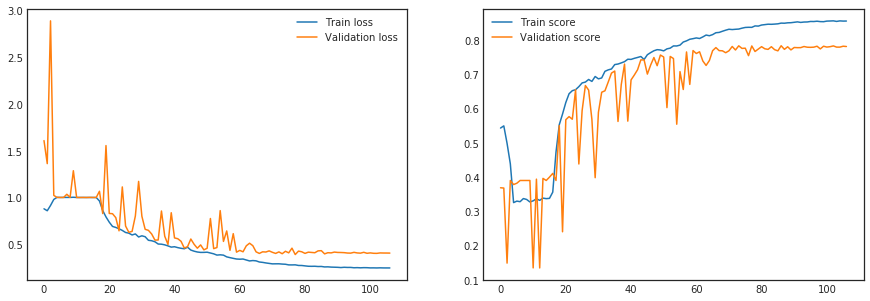

In [13]:
###################    lovasz model    #####################
print('-*-'*30)
# # load_version = 11.0
# # load_basic_name = f'Unet_resnet_v{load_version}'
# # load_model_name = load_basic_name + '.model'

load_model_name = save_model_name
print('LOAD MODEL:'+load_model_name)
print('-*-'*30)

model1 = load_model(load_model_name,custom_objects={'my_iou_metric': my_iou_metric,'bce_dice_loss':bce_dice_loss})
###remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
model.summary()

# model = load_model(load_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
#                                                    'lovasz_loss': lovasz_loss})
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2',
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)
epochs = 150
batch_size = 34
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 200
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping, TensorBoard(log_dir='mytensorboard/lovasz')],
                    verbose=2)

fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()


In [14]:
################## predict model ############
print('-*-'*30)
# load_version = 11.0
# load_basic_name = f'Unet_resnet_v{load_version}'
# load_model_name = load_basic_name + '.model'

load_model_name = save_model_name
print('LOAD MODEL:'+load_model_name)
print('-*-'*30)


model = load_model(load_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_hreflect =  np.array([np.fliplr(x) for x in x_test])
    # x_test_vreflect =  np.array([np.flipud(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_hreflect).reshape(-1, img_size_target, img_size_target)
    # preds_test3_refect = model.predict(x_test_vreflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    # preds_test += np.array([ np.flipud(x) for x in preds_test3_refect] )
    return preds_test/2

preds_valid = predict_result(model,x_valid,img_size_target=img_size_target)

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
LOAD MODEL:Unet_resnet_v50.0.model
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-



[0.77625  0.77675  0.7765   0.77625  0.77675  0.77675  0.77775  0.777625
 0.777625 0.778    0.778    0.77775  0.77925  0.780625 0.78075  0.780625
 0.780375 0.781125 0.782    0.783    0.78325  0.784375 0.78425  0.784625
 0.784875 0.7855   0.785    0.78475  0.786875 0.78675  0.785375]
-0.02666824708216118


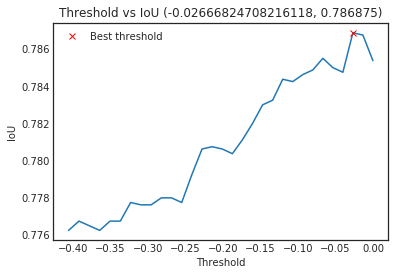

In [15]:

# Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0, 0.5, 1], [0, 0.5, 1]))
    #     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    # print(temp1)
    intersection = temp1[0]
    # print("temp2 = ",temp1[1])
    # print(intersection.shape)
    # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    # print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels, bins=[0, 0.5, 1])[0]
    # print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    intersection[intersection == 0] = 1e-9

    union = union[1:, 1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1  # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

## Scoring for last model, choose threshold by validation data
thresholds_ori = np.linspace(0.4, 0.5, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori))

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print(threshold_best)

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
# plt.show()

In [16]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


x_test = np.array([(upsample(np.array(load_img("./data/images/{}.png".format(idx), grayscale = True)))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target=img_size_target)
t1 = time.time()


# pred_dict = {idx: rle_encode(np.round(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")


/home/kylin/anaconda3/envs/py3.6/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/kylin/anaconda3/envs/py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Usedtime = 28.126678228378296 s
Kernel run time = 6.371084942287869 hours
